In [1]:
import scipy
import numpy as np
import seaborn as sns

import fiona
import rasterio

from shapely import geometry
from rasterio.mask import mask

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import matplotlib.colors as clr
plt.style.use('seaborn-whitegrid')

In [36]:
%matplotlib notebook

In [45]:
%matplotlib inline

In [3]:
BANDS = [461, 480, 490, 502, 516, 526, 540, 554, 555, 565, 578, 591, 600, 612, 622, # VIS
         671, 680, 707, 720, 733, 744, 758, 770, 783, 795, 815, 825, 836, 847, 857, 867, 877] # NIR

CODES = ['#007fff', '#00d5ff', '#00ffff', '#00ff7b', '#24ff00', '#4eff00', '#81ff00', '#b0ff00',
         '#b3ff00', '#d2ff00', '#f9ff00', '#ffdc00', '#ffbe00', '#ff9400', '#ff6f00',
         '#ff0000', '#ff0000', '#f20000', '#db0000', '#c20000', '#ad0000', '#910000', '#770000',
         '#000000', '#000000', '#000000', '#000000', '#000000', '#000000', '#000000', '#000000', '#000000']

BANDS_L = [461, 480, 490, 502, 516, 526, 540, 554, ' ', 565, 578, 591, 600, 612, 622, # VIS
         671, 680, 707, 720, 733, 744, 758, 770, 783, 795, 815, 825, 836, 847, 857, 867, 877] # NIR

In [4]:
hsi_pp_1 = rasterio.open("../data/pp_1/pp_1_hsi_clipped.tif")
hsi_pp_2 = rasterio.open("../data/pp_2/pp_2_hsi_clipped.tif")
hsi_pp_3 = rasterio.open("../data/pp_3/pp_3_hsi_clipped.tif")
hsi_pp_4 = rasterio.open("../data/pp_4/pp_4_hsi_clipped.tif")

chm_pp_1 = rasterio.open("../data/pp_1/pp_1_chm.tif")
chm_pp_2 = rasterio.open("../data/pp_2/pp_2_chm.tif")
chm_pp_3 = rasterio.open("../data/pp_3/pp_3_chm.tif")
chm_pp_4 = rasterio.open("../data/pp_4/pp_4_chm.tif")

trees_pp_2 = fiona.open("../data/pp_2/pp_2_trees_h/", "r")
trees_pp_3 = fiona.open("../data/pp_3/pp_3_trees_h/", "r")
trees_pp_4 = fiona.open("../data/pp_4/pp_4_trees_h/", "r")

In [5]:
def exclude_bad_pixels(image_instance):
    bad_pixels = np.where(image_instance[-1]==0)
    mask = (np.repeat(range(32), bad_pixels[0].shape[0]), 
            np.tile(bad_pixels[0], 32), 
            np.tile(bad_pixels[1], 32))
    image_instance[mask] = np.ma.masked
    

def get_trees(hsi_pp, chm_pp, trees_pp, hsi_radius=1.0, chm_radius=1.0):
    hsi_images, chm_images, labels, ids = [], [], [], []
    map_tree_speices = {'е':0, 'б':1, 'п':2, "El'":0, "Bereza":1, "Pichta":2, "Sosna":3} 
    
    for tree in trees_pp.values():
        tree_specie = tree['properties']['specie']
        labels.append(map_tree_speices[tree_specie])
        ids.append(tree['properties']['id_tree'])
        
        geometry_hsi = geometry.shape(tree['geometry']).buffer(hsi_radius)
        geometry_chm = geometry.shape(tree['geometry']).buffer(chm_radius)
        
        hsi_image, _ = mask(hsi_pp, [geometry_hsi], filled=False, crop=True)
        chm_image, _ = mask(chm_pp, [geometry_chm], filled=False, crop=True)
        
        exclude_bad_pixels(hsi_image)
        hsi_images.append(hsi_image/65535)
        chm_images.append(chm_image)
    
    return hsi_images, labels, chm_images, ids

In [6]:
RADIUS_HSI = 1.0
RADIUS_CHM = 2.0

tree_images_pp_2, tree_labels_pp_2, tree_chms_pp_2, tree_ids_pp_2 = get_trees(hsi_pp_2, chm_pp_2, trees_pp_2,
                                                                              hsi_radius=RADIUS_HSI, 
                                                                              chm_radius=RADIUS_CHM)
tree_images_pp_3, tree_labels_pp_3, tree_chms_pp_3, tree_ids_pp_3 = get_trees(hsi_pp_3, chm_pp_3, trees_pp_3,
                                                                              hsi_radius=RADIUS_HSI, 
                                                                              chm_radius=RADIUS_CHM)
tree_images_pp_4, tree_labels_pp_4, tree_chms_pp_4, tree_ids_pp_4 = get_trees(hsi_pp_4, chm_pp_4, trees_pp_4,
                                                                              hsi_radius=RADIUS_HSI, 
                                                                              chm_radius=RADIUS_CHM)

In [7]:
tree_labels_pp_2 = np.array(tree_labels_pp_2)
tree_labels_pp_3 = np.array(tree_labels_pp_3)
tree_labels_pp_4 = np.array(tree_labels_pp_4)

tree_ids_pp_2 = np.array(tree_ids_pp_2)
tree_ids_pp_3 = np.array(tree_ids_pp_3)
tree_ids_pp_4 = np.array(tree_ids_pp_4)

<IPython.core.display.Javascript object>


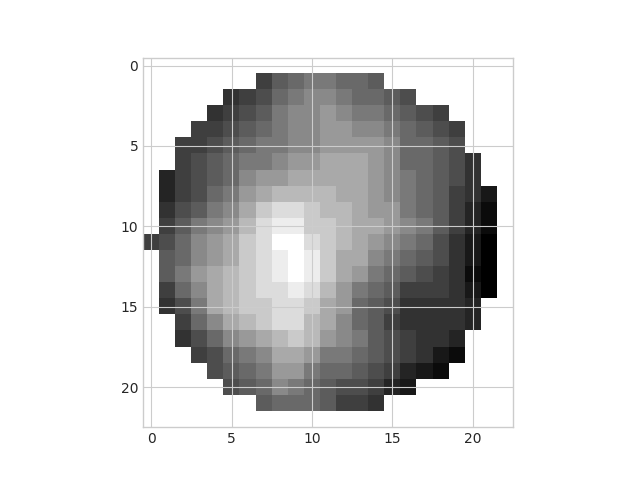

In [8]:
plt.imshow(tree_images_pp_2[148][0], cmap='gray')
plt.show()

### Features Calculation

In [8]:
def calculate_features(trees_images):
    mean_spectras, median_spectras = [], []
    mean_spectras_norm, median_spectras_norm = [], []
    
    for tree_image in trees_images:
        mean_spectra = [np.ma.mean(band) for band in tree_image]
        median_spectra = [np.ma.median(band) for band in tree_image]
        
        tree_image = tree_image/np.ma.sum(tree_image,axis=0)
        
        mean_spectra_norm = [np.ma.mean(band) for band in tree_image]
        median_spectra_norm = [np.ma.median(band) for band in tree_image]
        
        mean_spectras.append(mean_spectra)
        median_spectras.append(median_spectra)
        
        mean_spectras_norm.append(mean_spectra_norm)
        median_spectras_norm.append(median_spectra_norm)
    
    return (np.array(mean_spectras), np.array(median_spectras),
            np.array(mean_spectras_norm), np.array(median_spectras_norm))

In [9]:
(mean_spectra_pp_2, median_spectra_pp_2,
 mean_spectra_norm_pp_2, median_spectra_norm_pp_2) = calculate_features(tree_images_pp_2)

(mean_spectra_pp_3, median_spectra_pp_3,
 mean_spectra_norm_pp_3, median_spectra_norm_pp_3) = calculate_features(tree_images_pp_3)

(mean_spectra_pp_4, median_spectra_pp_4,
 mean_spectra_norm_pp_4, median_spectra_norm_pp_4) = calculate_features(tree_images_pp_4)

In [172]:
tree_features_pp_2 = np.hstack((mean_spectra_norm_pp_2, median_spectra_norm_pp_2))
tree_features_pp_3 = np.hstack((mean_spectra_norm_pp_3, median_spectra_norm_pp_3))
tree_features_pp_4 = np.hstack((mean_spectra_norm_pp_4, median_spectra_norm_pp_4))

tree_features = np.concatenate((tree_features_pp_2, tree_features_pp_3, tree_features_pp_4))
tree_labels = np.concatenate((tree_labels_pp_2, tree_labels_pp_3, tree_labels_pp_4))

In [10]:
tree_features = np.concatenate((mean_spectra_norm_pp_2, mean_spectra_norm_pp_3, mean_spectra_norm_pp_4))
tree_labels = np.concatenate((tree_labels_pp_2, tree_labels_pp_3, tree_labels_pp_4))

In [11]:
TREE_COLORS = {0:'g',1:'b',2:'r',3:'y'}

In [13]:
mean_spruce_pp_2 = np.mean(mean_spectra_norm_pp_2[np.where(tree_labels_pp_2==0)], axis=0)
mean_spruce_pp_3 = np.mean(mean_spectra_norm_pp_3[np.where(tree_labels_pp_3==0)], axis=0)
mean_spruce_pp_4 = np.mean(mean_spectra_norm_pp_4[np.where(tree_labels_pp_4==0)], axis=0)

mean_birch_pp_2 = np.mean(mean_spectra_norm_pp_2[np.where(tree_labels_pp_2==1)], axis=0)
mean_birch_pp_3 = np.mean(mean_spectra_norm_pp_3[np.where(tree_labels_pp_3==1)], axis=0)
mean_birch_pp_4 = np.mean(mean_spectra_norm_pp_4[np.where(tree_labels_pp_4==1)], axis=0)

mean_fir_pp_2 = np.mean(mean_spectra_norm_pp_2[np.where(tree_labels_pp_2==2)], axis=0)
mean_fir_pp_4 = np.mean(mean_spectra_norm_pp_4[np.where(tree_labels_pp_4==2)], axis=0)

mean_pine_pp_3 = np.mean(mean_spectra_norm_pp_3[np.where(tree_labels_pp_3==3)], axis=0)

<IPython.core.display.Javascript object>


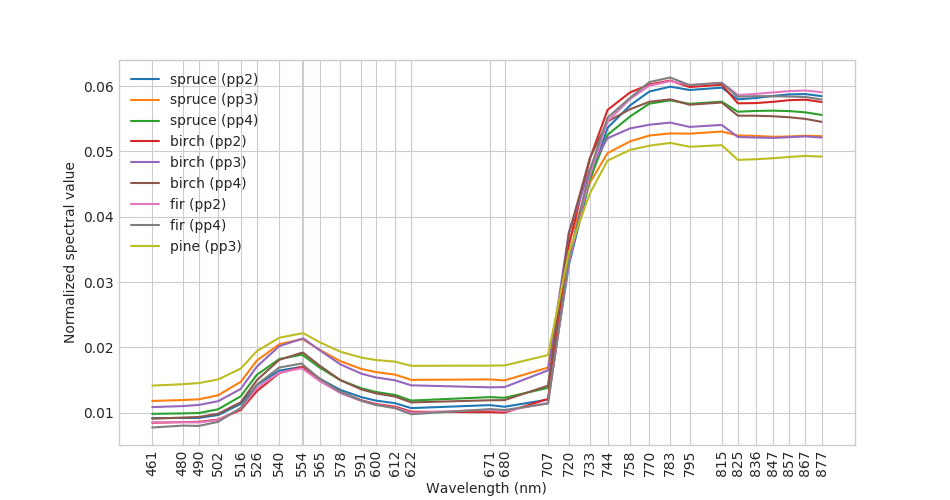

In [54]:
plt.figure(figsize=(9.5,5))
plt.plot(BANDS, mean_spruce_pp_2, label='spruce (pp2)')
plt.plot(BANDS, mean_spruce_pp_3, label='spruce (pp3)')
plt.plot(BANDS, mean_spruce_pp_4, label='spruce (pp4)')
plt.plot(BANDS, mean_birch_pp_2, label='birch (pp2)')
plt.plot(BANDS, mean_birch_pp_3, label='birch (pp3)')
plt.plot(BANDS, mean_birch_pp_4, label='birch (pp4)')
plt.plot(BANDS, mean_fir_pp_2, label='fir (pp2)')
plt.plot(BANDS, mean_fir_pp_4, label='fir (pp4)')
plt.plot(BANDS, mean_pine_pp_3, label='pine (pp3)')
plt.legend()    
plt.xticks(BANDS, labels=BANDS_L, rotation='vertical')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized spectral value')
plt.show()

<IPython.core.display.Javascript object>


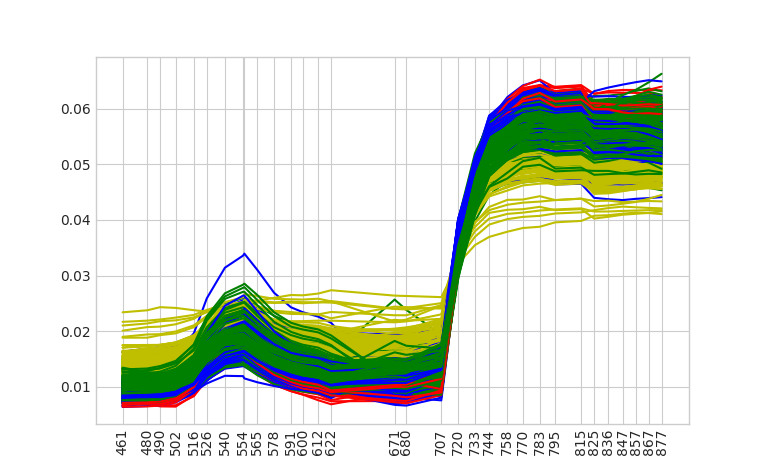

In [168]:
for i in range(len(tree_features)):
    plt.plot(BANDS, tree_features[i], c=TREE_COLORS[tree_labels[i]])
    
plt.xticks(BANDS, labels=BANDS_L, rotation='vertical')
plt.show()

In [11]:
from sklearn.utils import resample

from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, f1_score

### LOO Cross Validation

In [12]:
rfc = RandomForestClassifier(n_estimators=200)
knn = KNeighborsClassifier(n_neighbors=3)
svm_rbf = SVC(C=1000, kernel='rbf', gamma='scale')
svm_linear = SVC(C=1000, kernel='linear', gamma='scale')

In [13]:
y_preds, y_trues = [], []

loo = LeaveOneOut()

for train_index, test_index in tqdm_notebook(loo.split(tree_features), total=len(tree_features)):
    X_train, X_test = tree_features[train_index], tree_features[test_index]
    y_train, y_test = tree_labels[train_index], tree_labels[test_index]
    
    clf = knn
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    y_preds.append(y_pred[0])
    y_trues.append(y_test[0])

y_trues = np.array(y_trues)
y_preds = np.array(y_preds)

In [14]:
f1_score(y_trues, y_preds, average='macro')

0.7396797035679346

In [15]:
accuracy_score(y_trues, y_preds)

0.8862332695984704

<IPython.core.display.Javascript object>


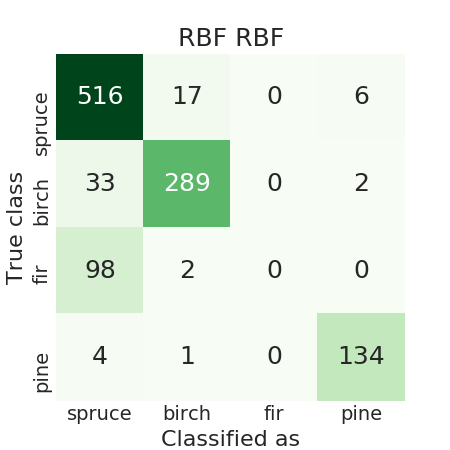

In [42]:
# manual confusion matrices printing

confusion_matrix = [[516,17,0,6], [33,289,0,2], [98,2,0,0], [4,1,0,134]]

plt.figure(figsize=(4.5,4.5))
g = sns.heatmap(confusion_matrix, annot=True, cbar=False, fmt='d', cmap='Greens', annot_kws={"size":18})
g.set_xticklabels(['spruce','birch','fir','pine'], rotation=0, fontsize=14)
g.set_yticklabels(['spruce','birch','fir','pine'], rotation=90, fontsize=14)
plt.xlabel('Classified as', fontsize=16)
plt.ylabel('True class', fontsize=16)
plt.title('RBF RBF', fontsize=18)
plt.show()

<IPython.core.display.Javascript object>


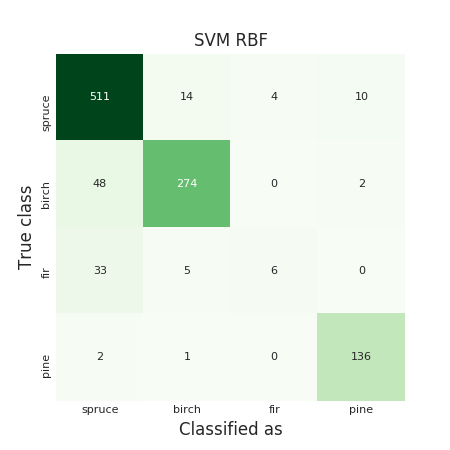

In [62]:
# automatic confusion matrices printing

plt.figure(figsize=(4.5,4.5))
g = sns.heatmap([np.bincount(y_preds[np.where(y_trues==i)], minlength=4) for i in range(4)],
                annot=True, cbar=False, fmt='d', cmap='Greens', annot_kws={"size":8})
g.set_xticklabels(['spruce','birch','fir','pine'], rotation=0, fontsize=8)
g.set_yticklabels(['spruce','birch','fir','pine'], rotation=90, fontsize=8)
plt.xlabel('Classified as', fontsize=12)
plt.ylabel('True class', fontsize=12)
plt.title('SVM RBF')
plt.show()

### K-Fold Cross Validation

In [64]:
clf = RandomForestClassifier(n_estimators=200)
cv_scores = cross_val_score(clf, tree_features, tree_labels, scoring='f1_micro', cv=10)
print(np.mean(cv_scores), np.std(cv_scores))

0.8831945985941546 0.056540612510417726


In [63]:
clf = KNeighborsClassifier(n_neighbors=3)
cv_scores = cross_val_score(clf, tree_features, tree_labels, scoring='accuracy', cv=10)
print(np.mean(cv_scores), np.std(cv_scores))

0.8612417826346794 0.059397991212400074


In [317]:
clf = GaussianNB(var_smoothing=3.111)
cv_scores = cross_val_score(clf, tree_features, tree_labels, scoring='accuracy', cv=40)
print(np.mean(cv_scores), np.std(cv_scores))

0.7498352490421456 0.12411254305636908


In [252]:
clf = MLPClassifier(max_iter=3000)
cv_scores = cross_val_score(clf, tree_features, tree_labels, scoring='accuracy', cv=3)
print(np.mean(cv_scores), np.std(cv_scores))

0.8231028762214612 0.06690717199462673


In [53]:
clf = SVC(C=1000, kernel='rbf', gamma='scale')
cv_scores = cross_val_score(clf, tree_features, tree_labels, scoring='f1_micro', cv=10)
print(np.mean(cv_scores), np.std(cv_scores))

0.8880930020774638 0.04305163234384253


In [54]:
clf = SVC(C=1000, kernel='linear')
cv_scores = cross_val_score(clf, tree_features, tree_labels, scoring='f1_micro', cv=10)
print(np.mean(cv_scores), np.std(cv_scores))

0.8688608099262927 0.05935501563773575


### UpSample Firs

In [16]:
UPSAMPLE = 100

In [17]:
tree_features_upsampled = np.delete(tree_features, np.where(tree_labels==2), axis=0)
tree_labels_upsampled = np.delete(tree_labels, np.where(tree_labels==2), axis=0)

In [18]:
fir_upsampled = resample(tree_features[np.where(tree_labels==2)], replace=True, n_samples=UPSAMPLE, random_state=26)

In [19]:
tree_features_upsampled = np.concatenate((tree_features_upsampled, fir_upsampled))
tree_labels_upsampled = np.concatenate((tree_labels_upsampled, np.repeat(2,UPSAMPLE)))

In [20]:
clf = RandomForestClassifier(n_estimators=200)
cv_scores = cross_val_score(clf, tree_features_upsampled, tree_labels_upsampled, scoring='accuracy', cv=10)
print(np.mean(cv_scores), np.std(cv_scores))

0.9037805987805987 0.046064069099559866


In [70]:
y_preds, y_trues = [], []

loo = LeaveOneOut()

for train_index, test_index in tqdm_notebook(loo.split(tree_features_upsampled), total=len(tree_features_upsampled)):
    X_train, X_test = tree_features_upsampled[train_index], tree_features_upsampled[test_index]
    y_train, y_test = tree_labels_upsampled[train_index], tree_labels_upsampled[test_index]
    
    clf = knn
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    y_preds.append(y_pred[0])
    y_trues.append(y_test[0])

y_trues = np.array(y_trues)
y_preds = np.array(y_preds)

In [71]:
f1_score(y_trues, y_preds, average='macro')

0.876445806634764

In [72]:
accuracy_score(y_trues, y_preds)

0.8883847549909256

### Feature Selection

In [21]:
estimator = RandomForestClassifier(n_estimators=200)
selector = RFECV(estimator, step=1, cv=10, scoring='accuracy')

In [29]:
estimator = RandomForestClassifier(n_estimators=200)
estimator.fit(tree_features_upsampled, tree_labels_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
np.argsort(estimator.feature_importances_, axis=0)[::-1]

array([19, 18, 20,  3,  4,  2, 27,  1, 26, 28, 16, 29, 21,  0, 30, 14, 31,
        5, 15, 17, 13,  7,  6, 22,  8, 23, 24, 12, 25,  9, 10, 11])

In [77]:
estimator = RandomForestClassifier(n_estimators=1000)
selector = RFE(estimator=estimator, n_features_to_select=1, step=1)

In [31]:
selector = selector.fit(tree_features_upsampled, tree_labels_upsampled)

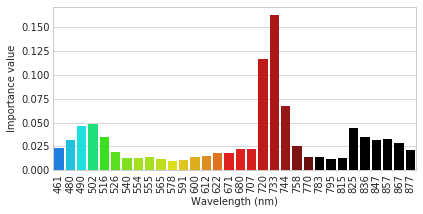

In [53]:
sns.set_palette(CODES)

plt.figure(figsize=(6.5,3))
g = sns.barplot(BANDS, estimator.feature_importances_, palette=sns.color_palette())
g.set_xticklabels(BANDS, rotation=90)
g.set_xlabel('Wavelength (nm)')
g.set_ylabel('Importance value')
# plt.plot([0.038]*32, '--', c='k')
plt.savefig('/Users/vasilii.mosin/Desktop/importances.png', dpi=150, bbox_inches = "tight")
plt.show()

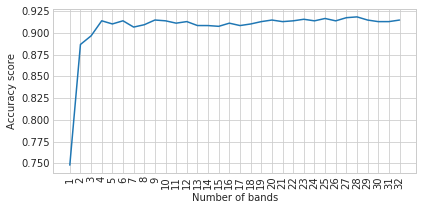

In [54]:
sns.set_palette('tab10')

plt.figure(figsize=(6.5,3))
plt.plot(range(1,33), selector.grid_scores_+0.01)
plt.xticks(range(1,33), range(1,33), rotation='vertical')
plt.xlabel('Number of bands')
plt.ylabel('Accuracy score')
# plt.plot([6.5]*18, np.arange(0.75,0.92,0.01), '--', c='k')
plt.savefig('/Users/vasilii.mosin/Desktop/importances_cv.png', dpi=150, bbox_inches = "tight")
plt.show()

In [425]:
np.argsort(selector.ranking_)

array([19,  3, 26, 20, 18,  2, 27,  1, 28,  4, 21, 29, 16, 17, 30,  0, 14,
        5, 22, 31, 15,  7, 13,  8, 23, 12,  6, 25,  9, 24, 11, 10])

In [27]:
clf = RandomForestClassifier(n_estimators=200)
clf.fit(tree_features_upsampled, tree_labels_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
import pickle

In [33]:
with open('./clf.pkl', 'wb') as clf_path:
    pickle.dump(clf, clf_path)

In [35]:
with open('./clf.pkl', 'rb') as clf_path:
    clf = pickle.load(clf_path)

## Pixel Based Approach

In [28]:
pixels_features_pp_2, pixels_labels_pp_2 = [], []
pixels_features_pp_3, pixels_labels_pp_3 = [], []
pixels_features_pp_4, pixels_labels_pp_4 = [], []

for i in range(len(tree_ids_pp_2)):
    tree_image = tree_images_pp_2[i]
    tree_image = tree_image/np.ma.sum(tree_image,axis=0)
    tree_image = tree_image.reshape(32,tree_image.shape[1]*tree_image.shape[2])
    tree_image = np.swapaxes(tree_image, 0, 1)
    pixel_features = np.array([pixel.data for pixel in tree_image if not pixel.mask.any()])
    pixels_features_pp_2.append(pixel_features)
    pixels_labels_pp_2.append(np.repeat(tree_labels_pp_2[i],len(pixel_features)))
    
for i in range(len(tree_ids_pp_3)):
    tree_image = tree_images_pp_3[i]
    tree_image = tree_image/np.ma.sum(tree_image,axis=0)
    tree_image = tree_image.reshape(32,tree_image.shape[1]*tree_image.shape[2])
    tree_image = np.swapaxes(tree_image, 0, 1)
    pixel_features = np.array([pixel.data for pixel in tree_image if not pixel.mask.any()])
    pixels_features_pp_3.append(pixel_features)
    pixels_labels_pp_3.append(np.repeat(tree_labels_pp_3[i],len(pixel_features)))
    
for i in range(len(tree_ids_pp_4)):
    tree_image = tree_images_pp_4[i]
    tree_image = tree_image/np.ma.sum(tree_image,axis=0)
    tree_image = tree_image.reshape(32,tree_image.shape[1]*tree_image.shape[2])
    tree_image = np.swapaxes(tree_image, 0, 1)
    pixel_features = np.array([pixel.data for pixel in tree_image if not pixel.mask.any()])
    pixels_features_pp_4.append(pixel_features)
    pixels_labels_pp_4.append(np.repeat(tree_labels_pp_4[i],len(pixel_features)))

In [29]:
pixels_features_pp_2 = np.array(pixels_features_pp_2)
pixels_features_pp_3 = np.array(pixels_features_pp_3)
pixels_features_pp_4 = np.array(pixels_features_pp_4)

In [30]:
pixels_labels_pp_2 = np.array(pixels_labels_pp_2)
pixels_labels_pp_3 = np.array(pixels_labels_pp_3)
pixels_labels_pp_4 = np.array(pixels_labels_pp_4)

In [31]:
pixels_features = np.concatenate((pixels_features_pp_2, pixels_features_pp_3, pixels_features_pp_4))
pixels_labels = np.concatenate((pixels_labels_pp_2, pixels_labels_pp_3, pixels_labels_pp_4))

In [34]:
scores = []
preds = {0:[],1:[],2:[],3:[]}

cv = KFold(n_splits=10)

for train_index, test_index in tqdm_notebook(cv.split(pixels_features), total=cv.n_splits):
    X_train, X_test = pixels_features[train_index], pixels_features[test_index]
    y_train, y_test = pixels_labels[train_index], pixels_labels[test_index]
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(np.concatenate(X_train), np.concatenate(y_train))
    for i in range(len(y_test)):
        pixels_preds = clf.predict(X_test[i])
        y_pred = np.argmax(np.bincount(pixels_preds))
        y_true = set(y_test[i]).pop()
        scores.append(accuracy_score([y_true], [y_pred]))
    
print(np.mean(scores))

0.9168260038240917


## Delineated Tree Crowns

In [23]:
from skimage.feature import peak_local_max
from skimage.filters import gaussian

In [1]:
image = hsi_pp_1.read()
ndvi = (image[24]-image[15])/(image[24]+image[15])

ndvi_mask = np.zeros_like(image[0])    
ndvi_mask[np.where(ndvi<0.6)] = 1

plt.imshow(ndvi_mask, cmap='gray')
plt.show()

NameError: name 'hsi_pp_1' is not defined

In [26]:
def tree_detection(input_layer_path, output_shapefile_path, smoothing=0, min_distance=3, mask=None):
    input_layer = rasterio.open(input_layer_path)
    input_raster = input_layer.read(1)
    if mask is not None:
        input_raster[np.where(mask)] = 0
    input_raster = gaussian(input_raster, sigma=smoothing)
    tree_tops = peak_local_max(input_raster, min_distance=min_distance, exclude_border=0, indices=True)
    
    schema = {'geometry': 'Point', 'properties': {'id': 'int'},}
    with fiona.open(output_shapefile_path, 'w', 'ESRI Shapefile', schema, input_layer.crs) as c:
        for i, tree_top in enumerate(tree_tops):
            tree_point = geometry.Point(input_layer.xy(tree_top[0], tree_top[1]))
            c.write({'geometry': geometry.mapping(tree_point), 'properties': {'id': i},})

In [199]:
def evaluate_detection(labeled_trees_path, detected_trees_path, circle_radius=1):    
    labeled_trees = fiona.open(labeled_trees_path, "r")
    detected_trees = fiona.open(detected_trees_path, "r")
    
    detections = []

    for tree in tqdm_notebook(labeled_trees.values(), total=len(labeled_trees)):
        trees_detected = 0
        tree_circle = geometry.shape(tree['geometry']).buffer(circle_radius)
        for detected_tree in detected_trees.values():
            tree_top = geometry.shape(detected_tree['geometry'])
            if tree_top.within(tree_circle):
                trees_detected += 1
        detections.append(trees_detected)
    
    return detections.count(1)/len(labeled_trees)

In [49]:
tree_detection('../data/pp_1/pp_1_chm.tif', '/Users/vasilii.mosin/Desktop/ForestHype/test_shapes/test_shape_01',
              smoothing=0.0, min_distance=3, mask=None)

In [50]:
len(fiona.open('/Users/vasilii.mosin/Desktop/ForestHype/test_shapes/test_shape_01'))

1790

In [375]:
evaluate_detection('../data/pp_4/pp_4_trees_h', '/Users/vasilii.mosin/Desktop/test_shapes/test_shape_01',
                   circle_radius=1.5)

0.7675840978593272

# Final Prediction

In [34]:
def classify_detected_trees(hsi_path, detected_trees_path, output_shapefile_path, clf):
    hsi = rasterio.open(hsi_path)
    detected_trees = fiona.open(detected_trees_path, 'r')
    
    map_tree_speices = {0:'spruce', 1:'birch', 2:'fir', 3:'pine'}
    schema = {'geometry': 'Point', 'properties': {'id': 'int', 'specie': 'str', 'proba': 'float'},}
    
    with fiona.open(output_shapefile_path, 'w', 'ESRI Shapefile', schema, detected_trees.crs) as c:     

        for detected_tree in tqdm_notebook(detected_trees.values(), total=len(detected_trees)):
            tree_point = geometry.shape(detected_tree['geometry'])
            tree_geometry = geometry.shape(detected_tree['geometry']).buffer(1.0)
            tree_image, _ = mask(hsi, [tree_geometry], filled=False, crop=True)
            exclude_bad_pixels(tree_image)
            tree_image = tree_image/65535

            tree_image = tree_image/np.ma.sum(tree_image,axis=0)
            mean_spectra_norm = np.array([np.ma.mean(band) for band in tree_image])
            prediction_probas = clf.predict_proba(mean_spectra_norm.reshape(1,-1))[0]
            prediction_specie = np.argmax(prediction_probas)

            c.write({'geometry': geometry.mapping(tree_point), 
                     'properties': {'id': detected_tree['properties']['id'],
                                    'specie': map_tree_speices[prediction_specie],
                                    'proba': prediction_probas[prediction_specie]}})

In [51]:
classify_detected_trees('../data/pp_1/pp_1_hsi_clipped.tif', 
                        '/Users/vasilii.mosin/Desktop/ForestHype/test_shapes/test_shape_01',
                        '/Users/vasilii.mosin/Desktop/ForestHype/test_shapes/pp_1_classified', clf)

In [52]:
classified_trees = fiona.open('/Users/vasilii.mosin/Desktop/ForestHype/test_shapes/pp_1_classified', 'r')

classified_trees_statistics = {'spruce':[], 'birch':[], 'fir':[], 'pine':[]}

for classified_tree in classified_trees.values():
    properties = classified_tree['properties']
    classified_trees_statistics[properties['specie']].append(properties['proba'])
    
for specie in classified_trees_statistics:
    specie_stats = classified_trees_statistics[specie]
    print(specie, '\t', len(specie_stats), '\t', np.mean(specie_stats), '\t', np.std(specie_stats))

spruce 	 1275 	 0.7742156862745098 	 0.1492484852257338
birch 	 297 	 0.8103535353535354 	 0.15214059463088517
fir 	 1 	 0.44 	 0.0
pine 	 217 	 0.6997235023041475 	 0.13160097856110636
